In [1]:
import gym
import sys
import numpy as np
import random as rn
import cv2
import time
import functools
import datetime
from collections import deque
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
ENVIRONMENT = "CartPole-v0"

# Overall
SEED = 789325
SAVE_EVERY_EPISODES = 100
UPDATE_TARGET_FREQUENCY = 10

# CartPole-v0
IS_CNN = False
LEARNING_START_AFTER_STEPS = 500
EPISODES = 110
SCORE_TO_SOLVE = 195.0

#### Set seed

In [3]:
rn.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Show Environment information

In [4]:
env = gym.make(ENVIRONMENT)
env.seed(SEED)

# size of each action
action_size = env.action_space.n
print('Actions: ', action_size)
if hasattr(env.env, 'get_action_meanings'):
    print(env.env.get_action_meanings())

# examine the state space 
states = env.observation_space.shape
state_size = states[0]
print('Size of state:', state_size)

env.close()

Actions:  2
Size of state: 4


# Agent

In [5]:
class SumTree(object):
    data_pointer = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)

    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update (tree_index, priority)
        self.data_pointer += 1
        
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0
            
    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
    
    def get_leaf(self, v):
        parent_index = 0
        
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else:                
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                    
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
            
        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0]

In [6]:
class PrioritizedReplayBuffer(object):
    PER_e = 0.01
    PER_a = 0.6
    PER_b = 0.4
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
    
    def add(self, experience):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        
        self.tree.add(max_priority, experience)

    def sample(self, n):        
        memory_b = []        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)                
        priority_segment = self.tree.total_priority / n    
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])        
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            index, priority, data = self.tree.get_leaf(value)
                        
            sampling_probabilities = priority / self.tree.total_priority
                        
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
                                   
            b_idx[i]= index
            
            experience = [data]
            
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)     

In [7]:
class Memory():
    def __init__(self, max_size=2000):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):        
        if len(self.buffer) <= self.max_size:
            self.buffer.append(experience)
        else:
            self.buffer[0] = experience 

    def sample(self, batch_size):
        return [], rn.sample(self.buffer, batch_size), []
    
    def batch_update(self, indices, td_errors):
        pass

In [8]:
class DDQNAgent:
    def __init__(self, 
                 state_size,
                 action_size,
                 model_builder_func,
                 preprocess_func,
                 use_PER=True,
                 buffer_size=10000,
                 batch_size=32,
                 gamma=0.99,
                 epsilon_start=1.0,
                 epsilon_min=0.1,
                 epsilon_steps_to_min=1000,
                 tau=0.1,                
                 pre_trained=None):
        
        self.state_size = state_size
        self.action_size = action_size
        self.use_PER = use_PER
        
        if self.use_PER:
            self.replay_buffer = PrioritizedReplayBuffer(capacity=buffer_size)
        else:
            self.replay_buffer = Memory(max_size=buffer_size)        
        
        self.batch_size = batch_size        
        self.gamma = gamma        
        self.epsilon = epsilon_start        
        self.epsilon_min = epsilon_min          
        self.epsilon_step = (self.epsilon - self.epsilon_min) / epsilon_steps_to_min
        self.tau = tau
        
        self.model = model_builder_func(state_size, action_size, pre_trained)
        self.target_model = model_builder_func(state_size, action_size, pre_trained)

        self.preprocess_func = preprocess_func
        
        self.hard_update_target_network()
    
    def hard_update_target_network(self):    
        pars = self.model.get_weights()
        self.target_model.set_weights(pars)
    
    def soft_update_target_network(self):
        pars_behavior = self.model.get_weights()
        pars_target = self.target_model.get_weights()
        
        ctr = 0
        for par_behavior,par_target in zip(pars_behavior,pars_target):
            par_target = par_target*(1-self.tau) + par_behavior*self.tau
            pars_target[ctr] = par_target
            ctr += 1

        self.target_model.set_weights(pars_target)
       
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add((state, action, reward, next_state, done)) 
          
    def preprocess(self, state):
        return self.preprocess_func(state, self.state_size)
            
    def act(self, state):
        # Update exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_step        
        
        # Choose Action
        if np.random.rand() <= self.epsilon:
            action = np.random.choice(self.action_size)
        else:            
            Qs = self.model.predict(state)[0]
            action = np.argmax(Qs)
                  
        return action          
    
    def train(self):
        indices, mini_batch, importance  = self.replay_buffer.sample(self.batch_size)
                        
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        Q_wants = []
        td_errors = np.zeros(self.batch_size)
        
        for i in range(len(mini_batch)):            
            if not self.use_PER:
                state, action, reward, next_state, done = mini_batch[i]
            else:
                state = mini_batch[i][0][0]
                action = mini_batch[i][0][1]
                reward = mini_batch[i][0][2]
                next_state = mini_batch[i][0][3]
                done = mini_batch[i][0][4]          
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
                    
        states_tensor = np.reshape(states,(self.batch_size,len(states[0])))
        Q_wants_pred = self.model.predict(states_tensor)
        
        next_states_tensor = np.reshape(next_states,(self.batch_size,len(next_states[0])))
        Q_next_state_vecs = self.model.predict(next_states_tensor)
        Q_target_next_state_vecs = self.target_model.predict(next_states_tensor)
            
        for i in range(len(mini_batch)):
            action = actions[i]
            reward = rewards[i]
            done = dones[i]
            
            Q_want = Q_wants_pred[i]
            Q_want_old = Q_want[action]
            
            if done:
                Q_want[action] = reward
            else:
                Q_next_state_vec = Q_next_state_vecs[i]
                action_max = np.argmax(Q_next_state_vec)
               
                Q_target_next_state_vec = Q_target_next_state_vecs[i]
                Q_target_next_state_max = Q_target_next_state_vec[action_max]
               
                Q_want[action] = reward + self.gamma*Q_target_next_state_max
                Q_want_tensor = np.reshape(Q_want,(1,len(Q_want)))
            
            Q_wants.append(Q_want)            
            td_errors[i] = abs(Q_want_old - Q_want[action])
          
        states = np.array(states)
        Q_wants = np.array(Q_wants)
        self.model.fit(states, Q_wants, verbose=False, epochs=1)

        # update replay buffer
        self.replay_buffer.batch_update(indices, np.array(td_errors))                
    
    def save(self, file='model.h5'):
        print('Save model...')
        self.model.save(file)    

# Environment

In [9]:
class Atari(object):
    def __init__(self, envName, seed=None, clip_rewards=False, frame_skip=None, null_op_max=30, cnn=True):
        self.env = gym.make(envName)        
        if seed is not None:
            self.env.seed(seed)

    def reset(self):
        state = self.env.reset()        
        return state
                          
    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        return next_state, reward, done, info

    def close(self):
        self.env.close() 

In [10]:
def build_Cartpole_v0_agent(pre_trained=None):
    def build_model(state_size, action_size, pre_trained):
        model = Sequential()
        model.add(Dense(64, input_dim=state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(action_size, activation='linear'))
        if pre_trained:            
            model = load_model(pre_trained)

        model.compile(optimizer=Adam(lr=0.001), loss='mse')
        return model    
    
    def build_model_duelling(state_size, action_size, pre_trained):
        model = Sequential()
        model.add(Dense(64, input_dim=state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(action_size + 1, activation='linear'))        
        model.add(Lambda(lambda i: K.expand_dims(i[:,0],-1) + i[:,1:] - K.mean(i[:,1:], keepdims=True), output_shape=(action_size,)))
        
        if pre_trained:            
            model = load_model(pre_trained)

        model.compile(optimizer=Adam(lr=0.001), loss='mse')        
        return model
    
    def preprocess(state, state_size):
        return np.reshape(state, [1, state_size])
    
    agent = DDQNAgent(state_size,
                     action_size,
                     build_model_duelling,
                     preprocess,
                     use_PER=True,
                     buffer_size=2000,
                     epsilon_start=0.5,
                     epsilon_steps_to_min=3500,
                     pre_trained=pre_trained)
    return agent

In [11]:
logdir = "logs/" + time.strftime("%Y%m%d_%H%M%S")
#logdir = "logs/" + "Duelling DDQN + PER loss='huber'"
#logdir = "logs/" + "Duelling DDQN + PER loss='huber'"
writer = tf.summary.create_file_writer(logdir)

In [12]:
def train():
    env = Atari(ENVIRONMENT, seed=SEED, clip_rewards=False, frame_skip=None,  cnn=IS_CNN)
    agent = build_Cartpole_v0_agent()
    
    max_reward = -9999999    
    game_rewards_deque = deque(maxlen=100)    
    frame_count = 0
    
    print("Training started: " + str(datetime.datetime.now()))
    
    frame_count = 0
    
    for i_episode in range(1, EPISODES+1):
        state = env.reset()
            
        game_reward = 0
        ep_loss = []
        
        starttime = datetime.datetime.now()
        
        steps = 0
        while True:
            frame_count += 1
            steps += 1
            
            state = agent.preprocess(state)                
            action = agent.act(state)            
            
            next_state, reward, done, info = env.step(action)              
            game_reward += reward
        
            agent.remember(state[0], action, reward, next_state, done)
            
            state = next_state
            
            if frame_count % 10000 == 0:
                print("Step count: {}".format(frame_count))
            
            if done:
                break            
            
            if frame_count > LEARNING_START_AFTER_STEPS:                
                agent.train()
                agent.soft_update_target_network()
                
            #if frame_count % UPDATE_TARGET_FREQUENCY == 0:
            #    agent.hard_update_target_network()
    
        # Log episode reward
        with writer.as_default():
            tf.summary.scalar("epsilon", agent.epsilon, step=i_episode)
            tf.summary.scalar("game_reward", game_reward, step=i_episode)        
            
        if i_episode % SAVE_EVERY_EPISODES == 0:
            print("Save after {} episodes.".format(i_episode))
            agent.save()             
        
        game_rewards_deque.append(game_reward)
        
        if game_reward > max_reward:
            print("Episode {}: Step {} reward {}: ".format(i_episode, frame_count, game_reward))
            max_reward = game_reward
            agent.save()        
        
        if np.mean(game_rewards_deque) >= SCORE_TO_SOLVE:
            agent.save()
            print("Solved in Episode {} Step {} reward {}: ".format(i_episode, frame_count, game_reward))
            break      
        
    agent.save()
    env.close()
    
train()
print("Training finished")

Training started: 2019-12-29 10:48:31.836427
Episode 1: Step 15 reward 15.0: 
Save model...
Episode 5: Step 80 reward 30.0: 
Save model...
Episode 6: Step 123 reward 43.0: 
Save model...
Episode 7: Step 180 reward 57.0: 
Save model...


c:\users\tobias\appdata\local\conda\conda\envs\openai\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\tobias\appdata\local\conda\conda\envs\openai\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


Episode 46: Step 860 reward 58.0: 
Save model...
Episode 47: Step 947 reward 87.0: 
Save model...
Episode 61: Step 1757 reward 92.0: 
Save model...
Episode 65: Step 2039 reward 105.0: 
Save model...
Episode 67: Step 2269 reward 133.0: 
Save model...
Episode 68: Step 2469 reward 200.0: 
Save model...
Save after 100 episodes.
Save model...
Step count: 10000
Save model...
Training finished


# Show Result

Episode finished with score: 156.0


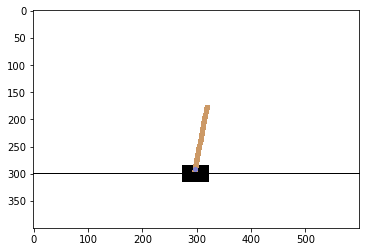

In [15]:
env = gym.make(ENVIRONMENT)
agent = build_Cartpole_v0_agent(pre_trained='model.h5')

state = env.reset()
final_reward = 0

img = plt.imshow(env.render(mode='rgb_array'))
while True:
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state = np.reshape(state, [1, state_size])
    action = agent.act(state)    
    next_state, reward, done, info = env.step(action)
    final_reward += reward 
    
    state = next_state
    
    if done:
        print("Episode finished with score: {}".format(final_reward))
        break
env.close()        